# <font color='orange'>***0. Get the dataset from kaggle***</font>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# <font color='orange'>***1. Download dependencies***</font>

In [ ]:
!pip install contractions

In [19]:
import nltk

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# <font color='orange'>***2. Import necessary libraries***</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# <font color='orange'>***3. Read the dataset***</font>

In [ ]:
# The datset directory
dataset_path = '/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
# Read the dataset in DataFrame
dataset_df = pd.read_csv(dataset_path)
# Show Random sample of data
dataset_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# <font color='orange'>***4. Cleaning and preprocessing***</font>

In [ ]:
# Remove nan entries
proc_dateset= dataset_df.dropna()
# Remove duplications in reviews and their coresponding sentiment
proc_dateset = dataset_df.drop_duplicates(subset=['review'])
# Reste the indicies
proc_dateset.reset_index(drop=True, inplace=True)

In [ ]:
proc_dateset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 774.8+ KB


**Text Cleaning**

In [ ]:
# Get english stop words (most frequent)
stop_words = stopwords.words('english')
# Get WordNetLemmatizer to get the context of words
lemmatizer = WordNetLemmatizer()

In [ ]:
# Expand contractions for better Text interpretations and stop words removal
def expand_contractions(text):
    # creating an empty list
    expanded_words1 = []
    for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_words1.append(contractions.fix(word))

    text = ' '.join(expanded_words1)

    contractions_dict = {
        "'m": " am",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'ll": " will",
        "'d": " would",
    }

    # Case-insensitive flag for the regular expression
    pattern = re.compile(r"\b(" + "|".join(re.escape(key) for key in contractions_dict.keys()) + r")\b", re.IGNORECASE)

    # Replace contractions with their expanded forms
    expanded_text = pattern.sub(lambda match: contractions_dict[match.group(0).lower()], text)

    return expanded_text

In [ ]:
text = """
Taha's playing football.I haven't seen Mary, but I'm sure she'll be at the party.
She's not the only one who won't come.
They're going to the store, aren't they?. Taha ain't good boy
"""
print('Original Text: ',text)
print()
print('Expanded text:\n',expand_contractions(text))

In [ ]:
# Remove stop words to reduce the dimensionality size and improve total performance
def stopWordsRemoval(sentence):
    filtered_sentence = []
    # Tokenize the sentence
    sentence =  word_tokenize(sentence)
    for w in sentence:
        if w not in stop_words:
            # Only append non stop words
            filtered_sentence.append(w)

    return ' '.join(filtered_sentence)

In [ ]:
text = """
Taha loves ML.
Ebrahim were playing an yoga.
"""
print('Original Text: ',text)
print()
print('After stop wors removal:\n',stopWordsRemoval(text))

In [ ]:
# This function will be used to help in lemmatization to get pos tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# For lemmatization (Lemmatization is similar to stemming but it brings context to the words)
def lemmatization(sentence):
    filtered_sentence = []
    sentence = word_tokenize(sentence)
    sentence = pos_tag(sentence)
    tokenCount = len(sentence)
    for i in range (0, tokenCount):
        t = sentence[i][0] # The token
        p = sentence[i][1] # The pos tag
        p = get_wordnet_pos(p)
        l = lemmatizer.lemmatize(t, pos = p)
        filtered_sentence.append(l)

    return ' '.join(filtered_sentence)

In [ ]:
lemmatization('is are playing saw had')

'be be play saw have'

**Final preprocessin and cleaning function**

In [ ]:
def text_preprocessing(text):
    # Matches Twitter handles.
    text = re.sub("(@[A-Za-z0-9]+)", " ",text)

    # Matches URLs.
    text = re.sub("(\w+:\/\/\S+)", " ",text)

    # Matches Hashtags
    text = re.sub(r'#\w*', ' ' , text)

    # Expand contradictions
    text = expand_contractions(text)

    # Convert text to lowercase
    text = text.lower()

    # Remove stop words like are, is, has ...
    text = stopWordsRemoval(text)

    # Lemmatization brings context to the words
    text = lemmatization(text)

    # Matches special characters letters, spaces, and tabs.
    text = re.sub("([^A-Za-z \t])", " ",text)

    # Remove extra white spaces
    text = " ".join(text.split())

    return text

In [ ]:
text = """
Taha's playing football. I'd played too much.
I'm love 😂🤣❤😘👀 my wife.
I haven't seen Mary, but I'm sure she'll be at the party.
he visit https://www.google.com/ too much.
#BFCAI #CS
@Taha 
"""

print('Original Text: ',text)
print()
print('Preprocessed text:\n',text_preprocessing(text))

**Apply the text preprocessing on the dataset**

In [ ]:
proc_dateset['review'] = proc_dateset['review'].apply(text_preprocessing)

<ipython-input-24-4ed9f32560b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proc_dateset['review'] = proc_dateset['review'].apply(text_preprocessing)


In [ ]:
# Remove empty reviews entries after processing
proc_dateset2 = proc_dateset[proc_dateset.review != '']

# Remove duplications in reviews and their coresponding sentiment
proc_dateset2 = proc_dateset2.drop_duplicates(subset=['review'])

# Reste the indicies
proc_dateset2.reset_index(drop=True, inplace=True)

In [ ]:
proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production br br film techniq...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49571,think movie right good job creative original f...,positive
49572,bad plot bad dialogue bad acting idiotic direc...,negative
49573,catholic teach parochial elementary school nun...,negative
49574,go disagree previous comment side maltin one s...,negative


**Encode sentiment labels**

In [ ]:
# Make object from label encoder class
lbl_encoder = LabelEncoder()
# Fit the encoder on the sentiment
lbl_encoder.fit(proc_dateset2['sentiment'])
# Transform sentiment classes to 0,1
proc_dateset2['sentiment'] = lbl_encoder.transform(proc_dateset2['sentiment'])

In [ ]:
lbl_encoder.classes_

array(['negative', 'positive'], dtype=object)

0 -> negative classe

1 -> postive class

In [ ]:
proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


In [ ]:
# To get most frequent words in every class
def top_words(data):
        words_list = data.split(' ')
        counts = Counter(words_list)
        top_words = counts.most_common(20)
        length_of_list = len(top_words)
        index = np.arange(length_of_list)
        print(top_words)
        count_values = [x[1] for x in top_words]
        count_words = [x[0] for x in top_words]
        fig = plt.figure(figsize = (16,9))
        bar_width = 0.4
        rects1 = plt.bar(index, count_values)
        plt.xticks(index + bar_width, count_words, rotation=0)
        plt.show()

Top words in Positive Sentiment
[('br', 97580), ('film', 50284), ('movie', 44524), ('one', 28166), ('see', 21633), ('make', 20174), ('like', 19451), ('good', 17047), ('time', 16304), ('get', 15948), ('well', 15207), ('great', 14241), ('story', 14101), ('character', 13923), ('would', 13227), ('go', 12693), ('show', 12014), ('watch', 11853), ('love', 11483), ('also', 10760)]


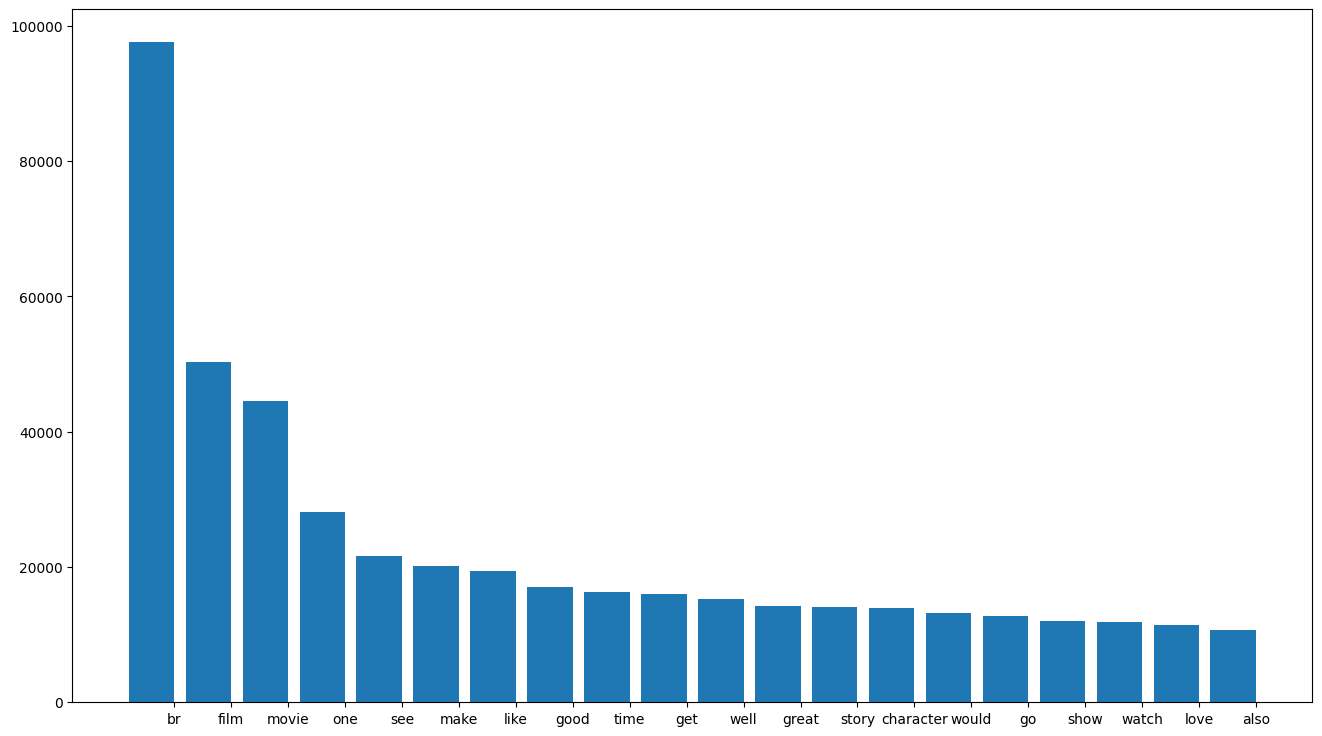

In [ ]:
train_positive_sentiment = proc_dateset2[proc_dateset2.sentiment == 1]
positive_words = ' '.join(train_positive_sentiment['review'])
print("Top words in Positive Sentiment")
top_words(positive_words)

Top words in Negative Sentiment
[('br', 102806), ('movie', 57662), ('film', 44075), ('one', 26852), ('make', 23630), ('like', 23625), ('bad', 20622), ('see', 19304), ('get', 19127), ('would', 17878), ('good', 17359), ('even', 15196), ('time', 14996), ('go', 14968), ('character', 14120), ('watch', 13648), ('really', 12216), ('well', 11880), ('look', 11295), ('could', 11259)]


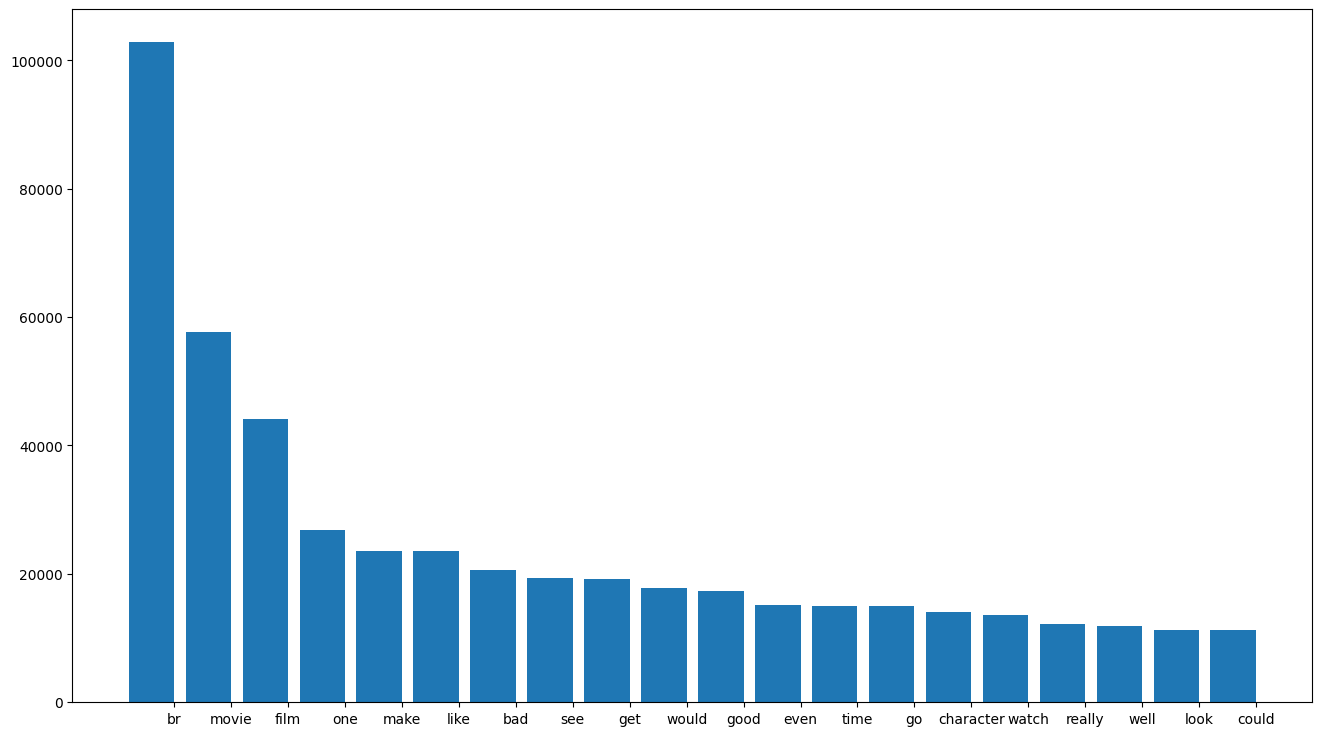

In [ ]:
train_negative_sentiment = proc_dateset2[proc_dateset2.sentiment == 0]
negative_words = ' '.join(train_negative_sentiment['review'])
print("Top words in Negative Sentiment")
top_words(negative_words)

In [ ]:
# Saving the dataframe
proc_dateset2.to_csv('Processes-dataset.csv')

**Read the processed dataset**

In [2]:
proc_dateset2 = pd.read_csv('Processes-dataset.csv')

proc_dateset2.drop(proc_dateset2.columns[0], axis=1, inplace=True)

proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


**Split data to train, test and validate**

In [3]:
x, x_test, y, y_test = train_test_split(
    proc_dateset2['review'],
    proc_dateset2['sentiment'],
    test_size=0.2,
    random_state= 42
)

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.33,
    random_state= 42
)

**Get number of rows for each subset**

In [5]:
print(x_train.shape[0])
print(x_val.shape[0])
print(x_test.shape[0])

26572
13088
9916


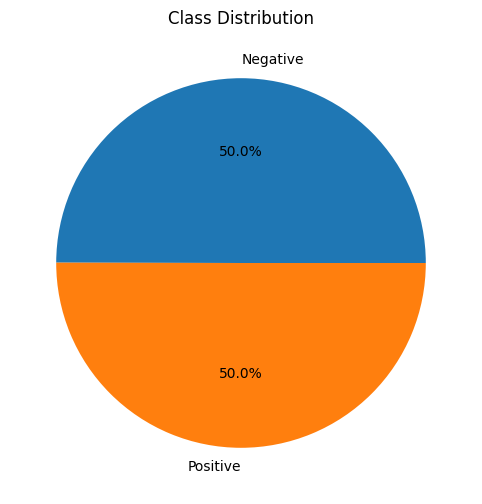

In [6]:
# Map the numerical labels to corresponding categories
classes = {0: 'Negative', 1: 'Positive'}

labels_description = np.array([classes[label] for label in y_train])

# Count the occurrences of each class in the 'labels_description' array
class_counts = np.unique(labels_description, return_counts=True)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts[1], labels=class_counts[0], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

**Encode text using tfidf**

In [5]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the train data
tf_x_train = tfidf_vectorizer.fit_transform(x_train)

In [6]:
print('Number of features is:\n',tfidf_vectorizer.get_feature_names_out().shape)

Number of features is:
 (69102,)


In [12]:
# Transform validation and test data
tf_x_val = tfidf_vectorizer.transform(x_val)
tf_x_test = tfidf_vectorizer.transform(x_test)

## <font color='orange'> ***Train models***</font>

In [8]:
def evaluate_model(clf, x_train, y_train, x_val, y_val):
    clf.fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_val = clf.predict(x_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    print(clf.__class__.__name__)
    print('Accuracy of training', acc_train)
    print('Accuracy of validation', acc_val)
    print('--------------------------')
    return acc_train, acc_val

**MultinomialNB**

In [9]:
mulnb_clf = MultinomialNB()

In [11]:
evaluate_model(mulnb_clf, tf_x_train, y_train, tf_x_val, y_val)

MultinomialNB
Accuracy of training 0.9105825681168147
Accuracy of validation 0.8591839853300733
--------------------------


(0.9105825681168147, 0.8591839853300733)